In [1]:
import numpy as np
import pandas as pd
import vtk
from dfninverse import DFNINVERSE
from numpy.random import randint, uniform, normal, random
from numpy.linalg import det, inv, norm
import matplotlib.pyplot as plt
from numpy import diff
from helper import latexify, vtk_show, vtk_meshrender, vtk_interactiveshow
from model import prior_probability, likelihood_ratio, Matrix_normal_distribution
%matplotlib inline

## Display the synthetic DFN Model and field observation

In [2]:
# Set synthetic model information
station_coordinates = [(0.4, 0.4, 0.2),   (0.4, 0.4, -0.2),    (0.4, -0.4, 0.2),
                       (0.4, -0.4, -0.2), (-0.15, -0.08, 0.2), (-0.15, -0.08, 0)]

syndfn_mesh = '/Volumes/SD_Card/Thesis_project/synthetic_model/output/full_mesh.vtk'
mesh_render = vtk_meshrender(syndfn_mesh, station_coordinates)
# vtk_show(mesh_render, 600, 600)

In [ ]:
# plot observation
syndfn_observation = '/Volumes/SD_Card/Thesis_project/synthetic_model/output/obs_readings.csv'
df = pd.read_csv(syndfn_observation, index_col=0)
fig = plt.figure(figsize=[8, 6])
for col in df.columns:
    plt.plot(np.arange(0, len(df)), df[col], label=col)
plt.xlabel('time step')
plt.ylabel('Pressure (Pa)')
plt.legend()
plt.title('Field Observation of the Synthetic DFN Model')
plt.show()

# Run Inversion

In [3]:
# Set inverse project information
project_path = '/Volumes/SD_Card/Thesis_project/dfn_test'
field_observation_file = '/Volumes/SD_Card/Thesis_project/synthetic_model/output/obs_readings.csv'
ncpu = 1

In [5]:
dfninv = DFNINVERSE(project_path, field_observation_file, station_coordinates, ncpu)
field_observation = dfninv.obs_data

In [6]:
# Define the initial fractures
observed_fractures = np.asarray([[-0.4, 0, 0, 0, np.pi / 2, 0.85],
                            [0.3, 0, 0.2, 0, np.pi / 2, 0.7],
                            [0.4, 0, -0.2, 0, np.pi / 2, 0.8]])
inferred_fractures = np.asarray([[-0.15, 0, 0.2, 0, 0, 0.8]])

n_inferred_frac = inferred_fractures.shape[0]
n_observed_frac = observed_fractures.shape[0]

n_total = n_inferred_frac + n_observed_frac

s_current = np.vstack((observed_fractures, inferred_fractures))
print(s_current)

[[-0.4         0.          0.          0.          1.57079633  0.85      ]
 [ 0.3         0.          0.2         0.          1.57079633  0.7       ]
 [ 0.4         0.         -0.2         0.          1.57079633  0.8       ]
 [-0.15        0.          0.2         0.          0.          0.8       ]]


In [7]:
# Define covariance matrix \Sigma_f, \Sigma_v
sig_obs = 0.0001
sig_unknown = 1
sig_cx = 0.05
sig_var = 0.0001

sig_f = np.hstack((sig_obs * np.ones(n_observed_frac), sig_unknown * np.ones(n_inferred_frac)))
sigma_f = np.diag(sig_f)

sig_v = np.hstack((sig_cx * np.ones(1), sig_var * np.ones(5)))
sigma_v = np.diag(sig_v)

In [8]:
# Initialize MCMC
prior_current = 1 #prior_probability(s_current)

dfninv.run_forward_simulation(s_current)
syn_data_current = dfninv.read_simulation_results()
rms_0, rms_1, ratio_0 = likelihood_ratio(syn_data_current, syn_data_current, field_observation)
status = {'model_id': 0, 'RMS': rms_0, 'fractures': s_current}
dfninv.save_accepted_model(status, model_id=0, save_flag=True)

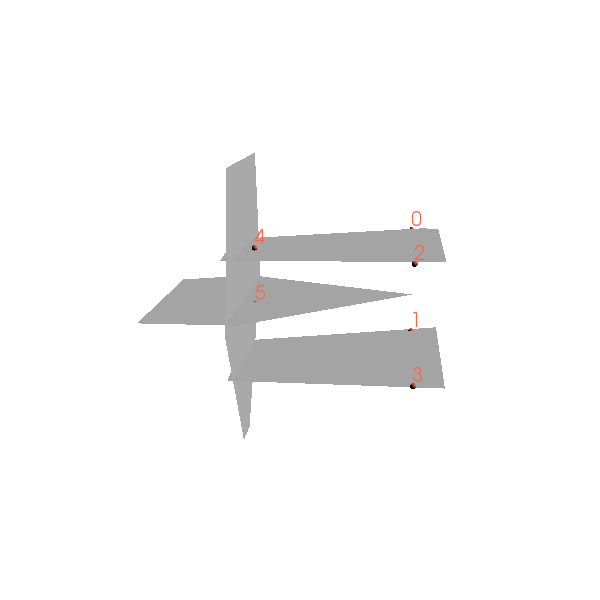

In [9]:
initial_dfn = project_path+'/accept_models/model_0/full_mesh.vtk'
camera_angle = [0, 30, 0]
dfnmesh_render = vtk_meshrender(initial_dfn, station_coordinates, camera_ang = camera_angle)
vtk_show(dfnmesh_render, 600, 600)

In [10]:
# Start loop
max_iteration = 100
i_iter = 0
accept_case = 0
model_trace = np.zeros([n_total, 6, max_iteration])

while i_iter < max_iteration:
    print('{0}Iteration:{1:d}{2}'.format('*' * 20, i_iter, '*' * 20))
    model_trace[:, :, 0] = s_current
    accept_flag = False

    s_proposed = Matrix_normal_distribution(s_current, sigma_f, sigma_v).get_proposal()
    dfninv.run_forward_simulation(s_proposed)
    syn_data_proposed = dfninv.read_simulation_results()
    prior_proposed = 1 #prior_probability(s_proposed)
    print(prior_proposed)
    print(s_proposed)
    rms_current, rms_proposed, ratio_ll = likelihood_ratio(syn_data_current, syn_data_proposed, field_observation)
    ratio_prior = prior_proposed / prior_current
    ratio_proposal = 1

    # calculate acceptance ratio
    alpha_1 = min(1, ratio_ll * ratio_prior * ratio_proposal)
    print(ratio_prior)
    print('Likelihood ratio = {:.2f}'.format(ratio_ll))
    print(alpha_1)
    # print('Acceptance Ratio = {:3f}'.format(alpha_1))

    if alpha_1 > random():
        accept_flag = True
        accept_case += 1

        s_current = s_proposed
        prior_current = prior_proposed
        rms_current = rms_proposed
        print('### Accept! RMS = {} ###'.format(rms_current))

    status = {'model_id': accept_case, 'RMS': rms_current, 'fractures': s_current}
    dfninv.save_accepted_model(status, model_id=accept_case, save_flag=accept_flag)
    i_iter += 1

********************Iteration:0********************
1
[[ -3.99996723e-01  -8.93328602e-09  -7.22029393e-09  -1.86624631e-09
    1.57079634e+00   8.49999997e-01]
 [  2.99999967e-01  -1.54175458e-09   2.00000008e-01  -4.70571883e-09
    1.57079632e+00   6.99999994e-01]
 [  4.00007526e-01   6.80697303e-09  -1.99999996e-01  -1.13349224e-08
    1.57079632e+00   8.00000013e-01]
 [ -2.17675573e-01   1.07661404e-04   1.99774444e-01  -2.69877540e-05
    3.86923630e-05   7.99785829e-01]]
1.0
Likelihood ratio = 0.40
0.398942280401
### Accept! RMS = 16.94206454130219 ###
********************Iteration:1********************
1
[[ -4.00001830e-01  -1.47145975e-08  -6.84601938e-09   1.08607337e-08
    1.57079635e+00   8.50000007e-01]
 [  3.00008569e-01   1.79464748e-08   1.99999991e-01   2.95693963e-09
    1.57079633e+00   7.00000011e-01]
 [  4.00010927e-01   1.03117346e-08  -1.99999982e-01  -8.78294476e-10
    1.57079633e+00   8.00000019e-01]
 [ -1.46332182e-01   2.32812269e-04   1.99691133e-01   3.26

********************Iteration:15********************
1
[[ -4.00022691e-01  -6.73815847e-08   2.23880771e-08   4.86275568e-08
    1.57079630e+00   8.50000066e-01]
 [  3.00023949e-01   1.01628200e-08   2.00000017e-01  -1.64778199e-09
    1.57079637e+00   7.00000012e-01]
 [  3.99999854e-01  -9.46037564e-09  -1.99999991e-01  -7.41098307e-09
    1.57079632e+00   8.00000023e-01]
 [  3.23226692e-02   1.18117699e-04   2.00205141e-01  -5.49037162e-05
   -4.81305933e-04   7.99924362e-01]]
1.0
Likelihood ratio = 258.43
1
### Accept! RMS = 3.9949241448912285 ###
********************Iteration:16********************
1
[[ -4.00033766e-01  -6.20234362e-08   1.32916166e-08   4.15585923e-08
    1.57079630e+00   8.50000065e-01]
 [  3.00021972e-01   9.40834439e-09   2.00000004e-01   4.29343214e-09
    1.57079637e+00   7.00000002e-01]
 [  3.99994990e-01  -7.71898748e-09  -1.99999974e-01  -7.81116206e-09
    1.57079631e+00   8.00000011e-01]
 [  4.94960619e-02  -5.95535722e-05   2.00345314e-01   1.33311784e-

1
[[ -4.00057690e-01  -5.63112599e-08   4.43879049e-08   3.15038554e-08
    1.57079634e+00   8.50000088e-01]
 [  3.00011811e-01   2.12766372e-08   2.00000028e-01  -1.99635967e-08
    1.57079643e+00   6.99999964e-01]
 [  3.99986397e-01  -2.11291606e-08  -2.00000037e-01   2.53472203e-08
    1.57079630e+00   8.00000047e-01]
 [ -1.33942984e-01   5.00341647e-04   1.99940823e-01   9.97441148e-05
   -5.59394647e-04   8.00483723e-01]]
1.0
Likelihood ratio = 4.76
1
### Accept! RMS = 11.985355045931925 ###
********************Iteration:31********************
1
[[ -4.00059895e-01  -6.12221709e-08   4.71289021e-08   3.23333619e-08
    1.57079634e+00   8.50000077e-01]
 [  3.00011610e-01   1.05689445e-08   2.00000029e-01  -2.49552379e-09
    1.57079642e+00   6.99999970e-01]
 [  3.99989755e-01  -1.85584626e-08  -2.00000035e-01   4.04439302e-08
    1.57079629e+00   8.00000043e-01]
 [ -1.28891773e-01   5.15265553e-04   1.99967655e-01   1.72602475e-04
   -6.27354254e-04   8.00537607e-01]]
1.0
Likelihood

1
[[ -4.00072930e-01  -9.52357583e-09   4.06909468e-08   4.61598897e-09
    1.57079635e+00   8.50000117e-01]
 [  3.00037183e-01  -1.25474336e-08   2.00000011e-01  -2.44659519e-08
    1.57079642e+00   6.99999962e-01]
 [  4.00007607e-01  -4.49888840e-09  -2.00000014e-01   1.15854933e-08
    1.57079632e+00   8.00000062e-01]
 [ -1.72737864e-01   5.19354514e-04   2.00220348e-01   1.52952563e-04
   -2.29412659e-04   8.00686867e-01]]
1.0
Likelihood ratio = 0.12
0.118312066056
### Accept! RMS = 19.373046510488376 ###
********************Iteration:46********************
1
[[ -4.00065128e-01  -1.98151768e-08   1.73976143e-08  -2.08858963e-08
    1.57079635e+00   8.50000124e-01]
 [  3.00036225e-01  -2.20775959e-08   2.00000014e-01  -3.48551255e-08
    1.57079643e+00   6.99999971e-01]
 [  4.00001038e-01  -1.58878756e-08  -2.00000011e-01   1.99662697e-08
    1.57079633e+00   8.00000058e-01]
 [ -1.70755185e-01   4.72232347e-04   2.00214087e-01   3.03736971e-04
   -1.25857264e-04   8.00668457e-01]]
1

********************Iteration:61********************
1
[[ -4.00081499e-01  -2.48137503e-08  -1.29107859e-08   4.76868079e-08
    1.57079637e+00   8.50000114e-01]
 [  3.00029934e-01  -5.52832317e-08   1.99999976e-01   9.68922975e-09
    1.57079643e+00   6.99999955e-01]
 [  4.00031619e-01   3.72297747e-09  -2.00000026e-01   2.38998241e-08
    1.57079634e+00   8.00000057e-01]
 [ -1.64781119e-01   9.25592464e-04   2.00283498e-01   1.28163670e-04
    4.49240924e-04   8.00449559e-01]]
1.0
Likelihood ratio = 0.12
0.118312066056
********************Iteration:62********************
1
[[ -4.00072917e-01  -1.56536521e-09  -7.98822220e-09   3.72252001e-08
    1.57079638e+00   8.50000083e-01]
 [  3.00026602e-01  -4.57258811e-08   1.99999962e-01  -6.47455683e-09
    1.57079643e+00   6.99999958e-01]
 [  4.00038421e-01   1.04824416e-08  -2.00000035e-01   4.61167737e-08
    1.57079632e+00   8.00000047e-01]
 [ -1.00532298e-01   8.80162840e-04   2.00343325e-01   9.48379204e-05
    4.78179747e-04   8.0067

********************Iteration:76********************
1
[[ -4.00117467e-01  -1.03406625e-08  -5.88802340e-08   1.18829025e-08
    1.57079643e+00   8.50000053e-01]
 [  2.99990699e-01  -7.88164441e-08   1.99999972e-01   6.24251671e-08
    1.57079645e+00   6.99999864e-01]
 [  4.00056700e-01   6.01996955e-08  -2.00000009e-01   6.36467313e-08
    1.57079632e+00   8.00000066e-01]
 [  1.56542670e-01   1.03264114e-03   2.00419296e-01   9.60195326e-04
   -5.41650406e-04   8.00577854e-01]]
1.0
Likelihood ratio = 501.92
1
### Accept! RMS = 2.667314198119339 ###
********************Iteration:77********************
1
[[ -4.00119388e-01  -4.41834033e-09  -6.07620193e-08   1.40020384e-08
    1.57079642e+00   8.50000057e-01]
 [  2.99992767e-01  -7.68802755e-08   1.99999973e-01   5.66236029e-08
    1.57079646e+00   6.99999880e-01]
 [  4.00060932e-01   6.71602824e-08  -2.00000029e-01   3.67915625e-08
    1.57079631e+00   8.00000083e-01]
 [  1.90191118e-01   1.08698987e-03   2.00392439e-01   9.86583992e-0

********************Iteration:91********************
1
[[ -4.00113101e-01  -1.09781929e-08  -8.57974852e-08   3.46590821e-08
    1.57079641e+00   8.50000021e-01]
 [  2.99997277e-01  -1.10140607e-07   1.99999970e-01   2.84795261e-08
    1.57079641e+00   6.99999906e-01]
 [  4.00086826e-01   9.33716036e-08  -2.00000039e-01  -1.33944545e-08
    1.57079637e+00   8.00000017e-01]
 [ -1.77674290e-01   1.05457016e-03   2.00424982e-01   1.94173102e-04
   -4.86112642e-04   8.00180304e-01]]
1.0
Likelihood ratio = 0.12
0.118312066056
********************Iteration:92********************
1
[[ -4.00109623e-01  -1.51055393e-08  -6.41870911e-08   4.44471494e-08
    1.57079640e+00   8.50000034e-01]
 [  2.99994152e-01  -1.11422984e-07   1.99999986e-01   3.06751267e-08
    1.57079641e+00   6.99999922e-01]
 [  4.00090139e-01   1.03665868e-07  -2.00000040e-01  -8.45868107e-09
    1.57079638e+00   8.00000039e-01]
 [ -9.31660218e-02   9.96444440e-04   2.00327207e-01   2.49656879e-04
   -4.16125567e-04   8.0017

In [11]:
# Analyze rms log
with open(project_path + '/mcmc_log.txt', 'r') as logfile:
    mcmc_log = logfile.readlines()
    separator = '*' * 60 + '\n'
    idx_sep = [i for i, j in enumerate(mcmc_log) if j == separator]

    n_fractures = idx_sep[1] - idx_sep[0] - 3
    n_model = len(idx_sep)
    
    rms = []
    for i in idx_sep:
        rms.append(float(mcmc_log[i+2].replace('\n', '')))

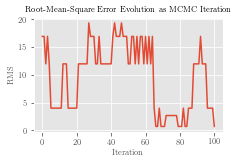

In [12]:
latexify()
fig = plt.figure()
plt.plot(rms)
plt.xlabel('Iteration')
plt.ylabel('RMS')
plt.title('Root-Mean-Square Error Evolution as MCMC Iteration')
plt.savefig(project_path + '/rms_iteration.pdf')
plt.show()

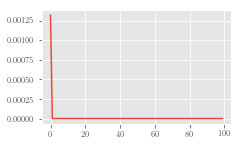

In [15]:
latexify()
fig = plt.figure()
cx = model_trace[3, 1, :]
plt.plot(cx)
# plt.xlabel('Iteration')
# plt.ylabel('RMS')
# plt.title('Root-Mean-Square Error Evolution as MCMC Iteration')
# plt.savefig(project_path + '/rms_iteration.pdf')
plt.show()

In [17]:
print(cx.shape)

(100,)
